<a href="https://colab.research.google.com/github/manzoniandrea/Geo-reconstruction_-ANN/blob/main/dataCategorization/%20Emilia_Romagna%20/%20Lithology_ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#libraries installation

In [ ]:
pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
pip install pyvista

#import libraries and database files

In [ ]:
import pandas as pd
import numpy as np

generale = pd.read_excel('Generale.xlsx')
strat = pd.read_excel('GEG_STRATIGRAFIE.xlsx')
lito = pd.read_excel('GEG_LITOLOGIE.xlsx')

eliminate the second litology (it can be used in future to fix where lito is not well definible)

In [ ]:
lito = lito[lito.ORDINE != 2]
lito = lito[lito.ORDINE != 3]
lito = lito[lito.ORDINE != 4]
lito = lito[lito.ORDINE != 5]

create dictionaries to relate the different database files

In [ ]:
litoDict = dict(zip(lito.ID_STRAT, lito.ID_TIPO_LITO))

In [ ]:
generaleDict = dict(zip(generale.GISID, generale.SIGLA))

create a single database

In [ ]:
wellLito_ER = strat
GISID = np.array(wellLito_ER.GISID)
ID_STRAT =  np.array(wellLito_ER.ID_STRAT)

In [ ]:
sigla = list(np.zeros(len(wellLito_ER.index)))
tipoLito = list(np.zeros(len(wellLito_ER.index)))
for i in range(len(wellLito_ER.index)):
  sigla[i] = generaleDict[GISID[i]]
  tipoLito[i] = litoDict[ID_STRAT[i]]
wellLito_ER['SIGLA'] = sigla
wellLito_ER['ID_TIPO_LITO'] = tipoLito

eliminate the useless columns

In [ ]:
wellLito_ER = wellLito_ER.drop(labels=['FLAG_GAS','FLAG_FILTRO','ID_ADDENSAMENTO','ID_CONS_PLAST','ID_QUANT_CC','ID_QUANT_CM','ID_QUANT_RV','ID_QUANT_FS','ID_SPESSORE','ID_FREQUENZA','ID_COLORE_PRI_1','ID_COLORE_PRI_2','ID_TONO_COL_PRI','ID_COLORE_SEC_1','ID_COLORE_SEC_2','ID_TONO_COL_SEC','ID_COLORE_PRI_1_INT','ID_COLORE_PRI_2_INT','ID_TONO_COL_PRI_INT','ID_COLORE_SEC_1_INT','ID_COLORE_SEC_2_INT','ID_TONO_COL_SEC_INT'], axis=1)

insert coordinates

In [ ]:
shape = pd.read_csv('coords_ER.csv')
XDict = dict(zip(shape.GISID, shape.Easting))
YDict = dict(zip(shape.GISID, shape.Northing))

In [ ]:
shape.Easting

0        881093.5
1        887598.0
2        887398.4
3        888092.8
4        888153.7
           ...   
15207    991562.8
15208    987864.8
15209    993834.6
15210    993570.7
15211    995686.3
Name: Easting, Length: 15212, dtype: float64

In [ ]:
coordsX = np.zeros(len(wellLito_ER.GISID))
coordsX[:] = np.NaN
coordsy = np.zeros(len(wellLito_ER.GISID))
coordsy[:] = np.NaN
for i in range(len(wellLito_ER.index)):
  if (i<111313)+(i>111329):
    coordsX[i] = XDict[wellLito_ER.GISID[i]]
    coordsy[i] = YDict[wellLito_ER.GISID[i]]
wellLito_ER['Easting'] = coordsX
wellLito_ER['Northing'] = coordsy

eliminate points w/o coordinates

In [ ]:

wellLito_ER = wellLito_ER.dropna(subset=['Easting'])

save dataframe

In [ ]:
import rasterio
src = rasterio.open('DEM_clip.tif')
coords = [(x,y) for x, y in zip( wellLito_ER.Easting, wellLito_ER.Northing)]

wellLito_ER.index = range(len(wellLito_ER))
wellLito_ER['Quota'] = [x[0] for x in src.sample(coords)]

calculate top and bottom of data layer

In [ ]:
offsetList = []
linSec = []
linVerts = []

i = 0

botLito = np.zeros(wellLito_ER.SIGLA.size)
topLito = np.zeros(wellLito_ER.SIGLA.size)

for layer in range(len(wellLito_ER.SIGLA)):
  x,y,z = wellLito_ER.loc[layer][['Easting','Northing','Quota']]
  topLito[layer] = wellLito_ER.Quota[layer]-wellLito_ER.TETTO[layer]
  botLito[layer] = wellLito_ER.Quota[layer]-wellLito_ER.BASE[layer]
  cellVerts = [[x,y,topLito[layer]],[x,y,botLito[layer]]]
  offsetList.append(i*3)
  linSec = linSec + [2,2*i,2*i+1]
  linVerts = linVerts + cellVerts
  i+=1
  if topLito[layer] > wellLito_ER.Quota[layer]:
    print(layer)

offsetArray = np.array(offsetList)
linArray = np.array(linSec)
cellType = np.ones([i])*3
vertArray = np.array(linVerts)

wellLito_ER['top_Layer'] = topLito
wellLito_ER['bttom_Layer'] =  botLito

#categorization

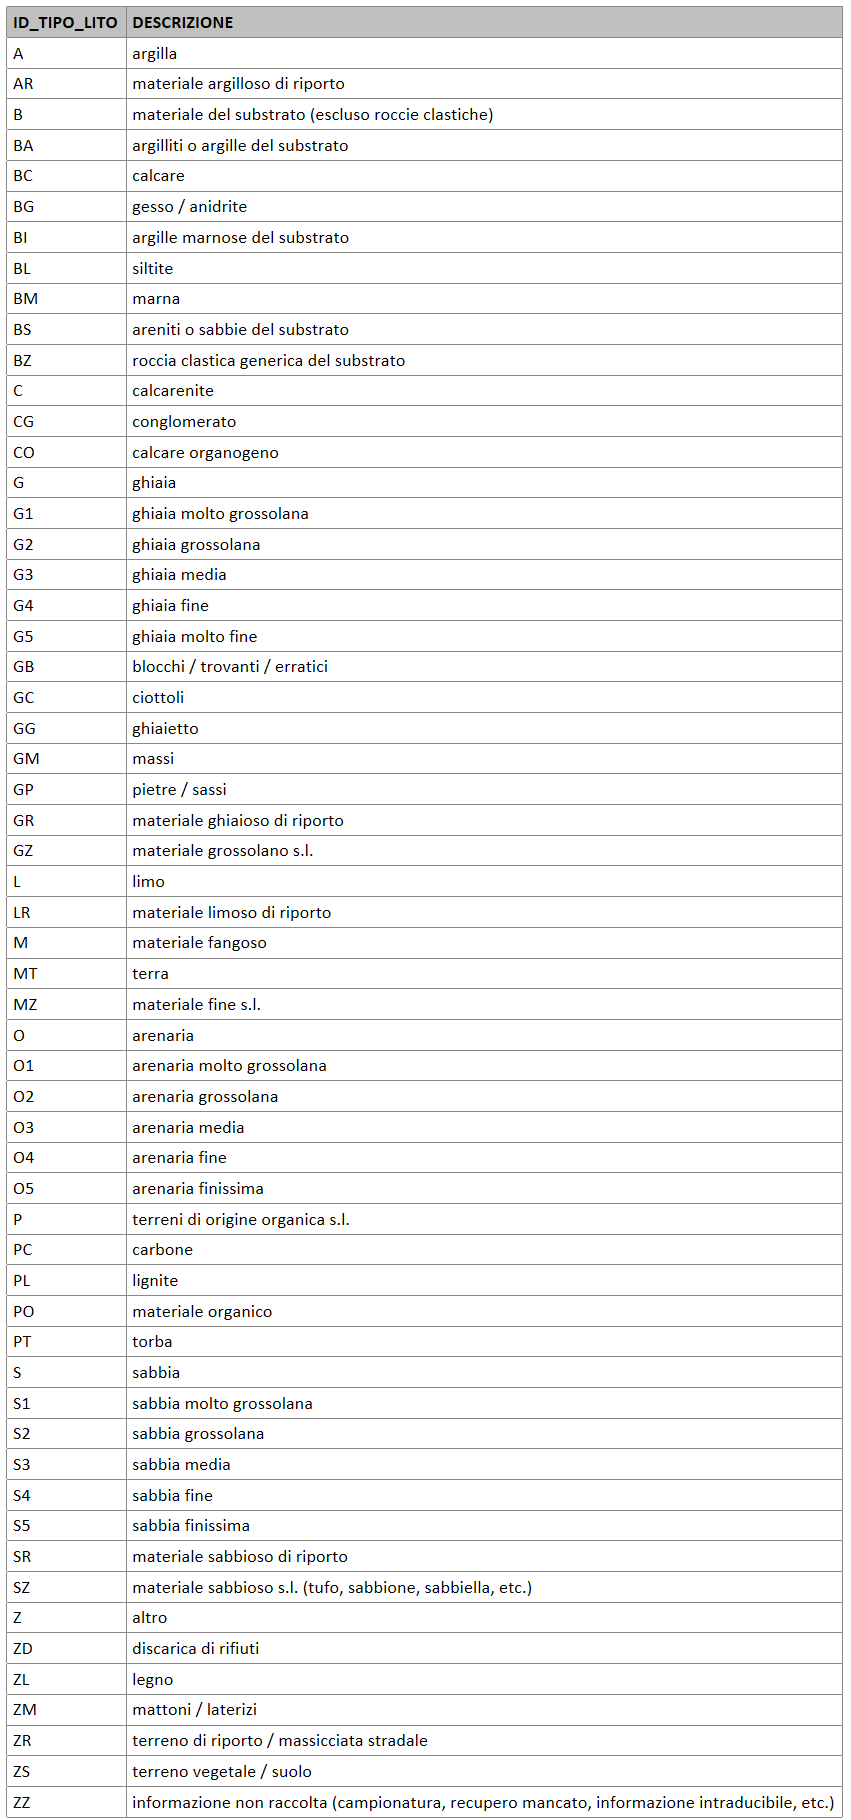

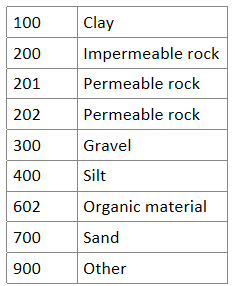

In [ ]:
litoCodeDict = {'A'	:	100,
'AR':	100,
'B'	:	200,
'BA':	200,
'BC':	201,
'BG':	201,
'BI':	100,
'BL':	201,
'BM':	201,
'BS':	202,
'BZ':	202,
'C'	:	201,
'CG':	900,
'CO':	201,
'G' :	300,
'G1':	300,
'G2':	300,
'G3':	300,
'G4':	300,
'G5':	300,
'GB':	900,
'GC':	300,
'GG':	300,
'GM':	300,
'GP':	300,
'GR':	300,
'GZ':	900,
'L'	:	400,
'LR':	400,
'M'	:	602,
'MT':	602,
'MZ':	900,
'O'	:	202,
'O1': 202,
'O2': 202,
'O3':	202,
'O4':	202,
'O5':	202,
'P'	:	602,
'PC':	900,
'PL':	900,
'PO':	602,
'PT':	602,
'S'	:	700,
'S1':	700,
'S2':	700,
'S3':	700,
'S4':	700,
'S5':	700,
'SR':	700,
'SZ':	700,
'Z'	:	900,
'ZD':	900,
'ZL': 900,
'ZM':	900,
'ZR':	900,
'ZS':	602,
'ZZ':	900,}

In [ ]:
l1 = list(wellLito_ER.ID_TIPO_LITO)
for k in range(len(l1)):
  l1[k] = litoCodeDict[l1[k]]
wellLito_ER['l1'] = l1

#save and export data

In [ ]:
wellLito_ER.to_csv('wellLito_ER.csv')

In [ ]:
import pyvista as pv
# creo un file di visualizzazione dei risultati
grid = pv.UnstructuredGrid(offsetArray, linArray, cellType, vertArray)
grid.cell_arrays["values"] = wellLito_ER.l1.values
grid.save('wellLito_ER.vtu',binary=False)